# P_bar deep dive

I fear this step of moving from rho to p_bar is providing quite difficult. This notebook is going to be a very careful deep dive into each step in the process, probably for individual profiles. Or at least for a few at a time. I really hope this goes well.

Editing this from VS Code!!

In [1]:
import xarray as xr
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.path import Path
import matplotlib.colors as colors
import pandas as pd
import numpy as np
from importlib import reload
import cartopy.crs as ccrs
import cmocean.cm as cmo
import gsw
import scipy.ndimage as filter
import scipy.interpolate as interpolate

In [2]:
import os
os.chdir('/home/amf2288/argo-intern/funcs')
import filt_funcs as ff
import density_funcs as df

In [3]:
plt.rcParams['axes.titleweight'] = 'bold'
plt.rcParams['axes.titlesize']  = 18
plt.rcParams['axes.labelsize']  = 14
plt.rcParams['xtick.labelsize'] = 14
plt.rcParams['ytick.labelsize'] = 14
plt.rcParams['legend.fontsize'] = 14

## Load Section

In [4]:
ds_x = xr.open_dataset('/swot/SUM05/amf2288/sync-boxes/ds_high_res_1.nc')

In [5]:
section = ds_x.where((ds_x.LATITUDE < -25) & (ds_x.LATITUDE > -35),drop=True).where((ds_x.LONGITUDE < -138) & (ds_x.LONGITUDE > -140),drop=True).sortby('LATITUDE')

In [6]:
section = section.sortby('N_PROF')

#only keep profiles with at least n data points
ct_counts = section['CT'].count(dim='PRES_INTERPOLATED')
profiles_to_keep = ct_counts >= 500
section_p = section.sel(N_PROF=profiles_to_keep).sortby('LATITUDE')

In [7]:
section_p = section_p.rename({'PRES':'PRESSURE','PRES_INTERPOLATED':'PRES','N_PROF':'PROF','LATITUDE':'LAT','LONGITUDE':'LON'})

In [8]:
section_p['SIG1'] = (('PROF','PRES'), gsw.density.sigma1(section_p.SA, section_p.CT).values)

In [9]:
nprof = section_p.dims["PROF"]
section_p = section_p.assign_coords(NUM=("PROF", np.arange(nprof)))

/home/amf2288/miniconda3/envs/Argo_Feb_25/lib/python3.11/site-packages/xarray/core/utils.py:494: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  warnings.warn(


In [10]:
section_p

<xarray.Dataset>
Dimensions:          (PROF: 409, PRES: 1001)
Coordinates:
  * PRES             (PRES) int64 0 2 4 6 8 10 ... 1990 1992 1994 1996 1998 2000
  * PROF             (PROF) int64 1983300 1983280 1984183 ... 1264653 1263963
    TIME             (PROF) datetime64[ns] 2018-03-28T01:11:23 ... 2017-09-25...
    LAT              (PROF) float64 -34.9 -34.88 -34.81 ... -25.3 -25.1 -25.1
    LON              (PROF) float64 -138.6 -138.7 -138.5 ... -139.6 -139.4
    NUM              (PROF) int64 0 1 2 3 4 5 6 ... 402 403 404 405 406 407 408
Data variables:
    CT               (PROF, PRES) float64 nan 20.88 20.89 ... 1.968 1.966 nan
    CYCLE_NUMBER     (PROF, PRES) float64 nan 95.0 95.0 95.0 ... 76.0 76.0 nan
    PLATFORM_NUMBER  (PROF, PRES) float64 nan 5.902e+06 ... 5.902e+06 nan
    PRESSURE         (PROF, PRES) float32 nan 2.0 4.0 ... 1.998e+03 nan
    PSAL             (PROF, PRES) float32 nan 34.59 34.59 ... 34.63 34.63 nan
    SA               (PROF, PRES) float64 nan 34.75 34.75 ... 34.8 34.8 nan
    SIG0             (PROF, PRES) float64 nan 24.22 24.22 ... 27.69 27.69 nan
    TEMP             (PROF, PRES) float32 nan 20.88 20.88 ... 2.106 2.104 nan
    sample_rate      (PROF, PRES) float32 nan 0.9 1.0 1.091 ... 1.9 2.0 2.0 nan
    SPICE            (PROF, PRES) float64 nan 3.434 3.436 ... -0.1042 nan
    SIG1             (PROF, PRES) float64 nan 28.48 28.48 ... 32.34 32.34 nan
Attributes:
    DATA_ID:              ARGO
    DOI:                  http://doi.org/10.17882/42182
    Fetched_from:         https://data-argo.ifremer.fr
    Fetched_by:           amf2288
    Fetched_date:         2025/03/11
    Fetched_constraints:  [x=0.00/5.00; y=40.00/45.00; z=0.0/2002.0]
    Fetched_uri:          
    Valid uris:           ['https://data-argo.ifremer.fr/dac/coriolis/6903068...
    All uris:             ['https://data-argo.ifremer.fr/dac/coriolis/6903068...
    Processing_history:   [PRES,TEMP,PSAL] real-time and adjusted/delayed var...

## Preprocessing: sort by density and reindex

In [11]:
def sorting_index_from_sig(sig):
    """
    sig0: 1D numpy array for a single profile.
    Returns: 1D array of indices (same length) that sorts the valid region
             and leaves NaNs at the edges.
    """
    valid = ~np.isnan(sig)

    if not np.any(valid):
        return np.arange(len(sig))  # nothing to sort

    # valid region boundaries
    i0 = np.argmax(valid)
    i1 = len(sig) - np.argmax(valid[::-1])

    # sorting index for the core region
    core = sig[i0:i1]
    core_sort_idx = np.argsort(core)

    # build full index array
    full_idx = np.arange(len(sig))
    full_idx[i0:i1] = full_idx[i0:i1][core_sort_idx]

    return full_idx

In [12]:
sort0_idx = xr.apply_ufunc(
    sorting_index_from_sig,
    section_p["SIG0"],
    input_core_dims=[["PRES"]],
    output_core_dims=[["PRES"]],
    vectorize=True,
    dask="parallelized",
    output_dtypes=[int],
)

sort1_idx = xr.apply_ufunc(
    sorting_index_from_sig,
    section_p["SIG1"],
    input_core_dims=[["PRES"]],
    output_core_dims=[["PRES"]],
    vectorize=True,
    dask="parallelized",
    output_dtypes=[int],
)

In [13]:
def apply_sort_index(var, sort_idx, dim="PRES"):
    return xr.apply_ufunc(
        lambda v, idx: v[idx],
        var,
        sort_idx,
        input_core_dims=[[dim], [dim]],
        output_core_dims=[[dim]],
        vectorize=True,
        dask="parallelized",
        output_dtypes=[var.dtype],
    )

In [14]:
section_p["SIG0_sort0"] = apply_sort_index(section_p["SIG0"], sort0_idx)
section_p["SIG1_sort1"] = apply_sort_index(section_p["SIG1"], sort1_idx)

In [15]:
vars_to_sort = ["CT", "SA", "TEMP", "PSAL", "PRESSURE", "SPICE"]

for v in vars_to_sort:
    section_p[f"{v}_sort0"] = apply_sort_index(section_p[v], sort0_idx)
    
for v in vars_to_sort:
    section_p[f"{v}_sort1"] = apply_sort_index(section_p[v], sort1_idx)

In [16]:
x = 'NUM'
section_p = section_p.sortby(x)

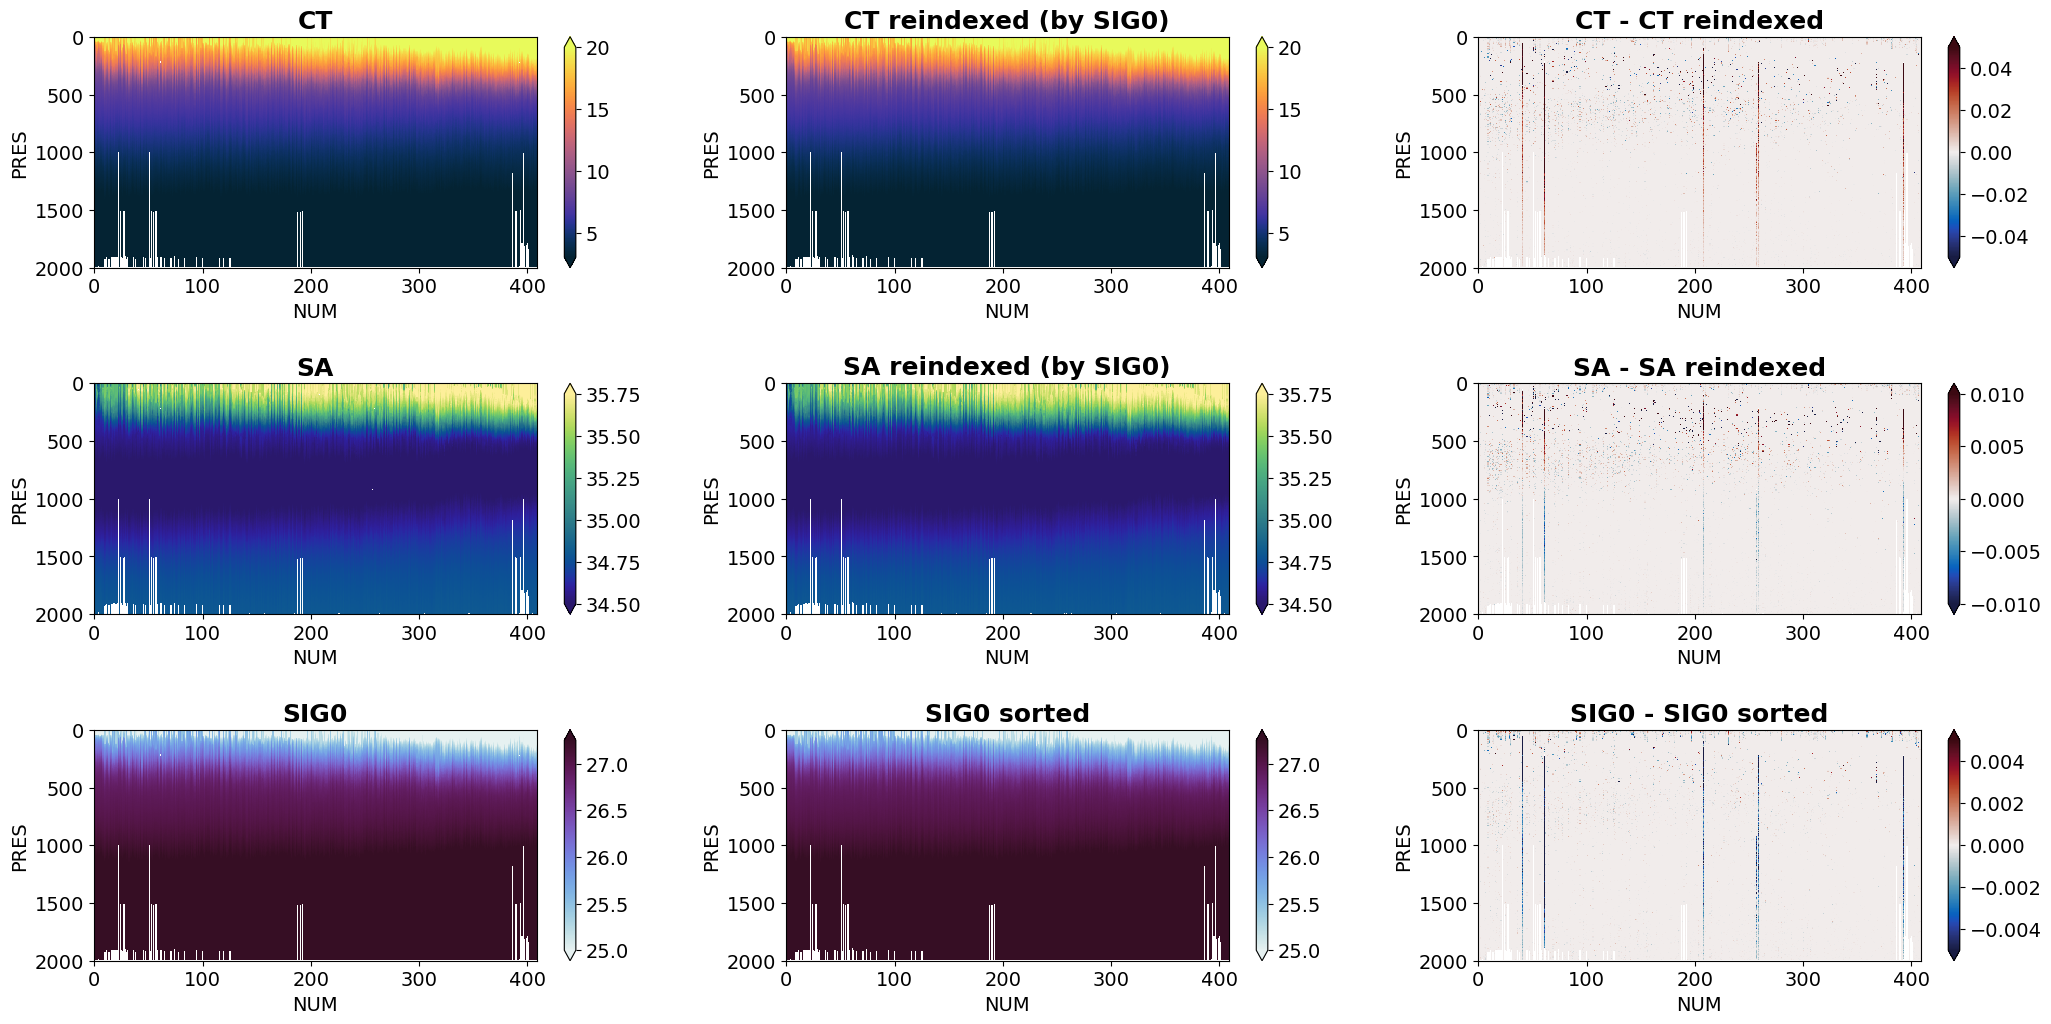

In [17]:
plt.figure(figsize=(25,12))

plt.subplot(331)
section_p.CT.plot(x=x, y='PRES', cmap=cmo.thermal, vmin=3, vmax=20, cbar_kwargs={'label':''})
plt.gca().invert_yaxis()
plt.title('CT')

plt.subplot(332)
section_p.CT_sort0.plot(x=x, y='PRES', cmap=cmo.thermal, vmin=3, vmax=20, cbar_kwargs={'label':''})
plt.gca().invert_yaxis()
plt.title('CT reindexed (by SIG0)')

plt.subplot(333)
(section_p.CT - section_p.CT_sort0).plot(x=x, y='PRES', cmap=cmo.balance, vmin=-0.05, vmax=0.05, cbar_kwargs={'label':''})
plt.gca().invert_yaxis()
plt.title('CT - CT reindexed')

plt.subplot(334)
section_p.SA.plot(x=x, y='PRES', cmap=cmo.haline, vmin=34.5, vmax=35.75, cbar_kwargs={'label':''})
plt.gca().invert_yaxis()
plt.title('SA')

plt.subplot(335)
section_p.SA_sort0.plot(x=x, y='PRES', cmap=cmo.haline, vmin=34.5, vmax=35.75, cbar_kwargs={'label':''})
plt.gca().invert_yaxis()
plt.title('SA reindexed (by SIG0)')

plt.subplot(336)
(section_p.SA - section_p.SA_sort0).plot(x=x, y='PRES', cmap=cmo.balance, vmin=-0.01, vmax=0.01, cbar_kwargs={'label':''})
plt.gca().invert_yaxis()
plt.title('SA - SA reindexed')

plt.subplot(337)
section_p.SIG0.plot(x=x, y='PRES', cmap=cmo.dense, vmin=25, vmax=27.25, cbar_kwargs={'label':''})
plt.gca().invert_yaxis()
plt.title('SIG0')

plt.subplot(338)
section_p.SIG0_sort0.plot(x=x, y='PRES', cmap=cmo.dense, vmin=25, vmax=27.25, cbar_kwargs={'label':''})
plt.gca().invert_yaxis()
plt.title('SIG0 sorted')

plt.subplot(339)
(section_p.SIG0 - section_p.SIG0_sort0).plot(x=x, y='PRES', cmap=cmo.balance, vmin=-0.005, vmax=0.005, cbar_kwargs={'label':''})
plt.gca().invert_yaxis()
plt.title('SIG0 - SIG0 sorted')

plt.subplots_adjust(wspace=0.25, hspace=0.5)

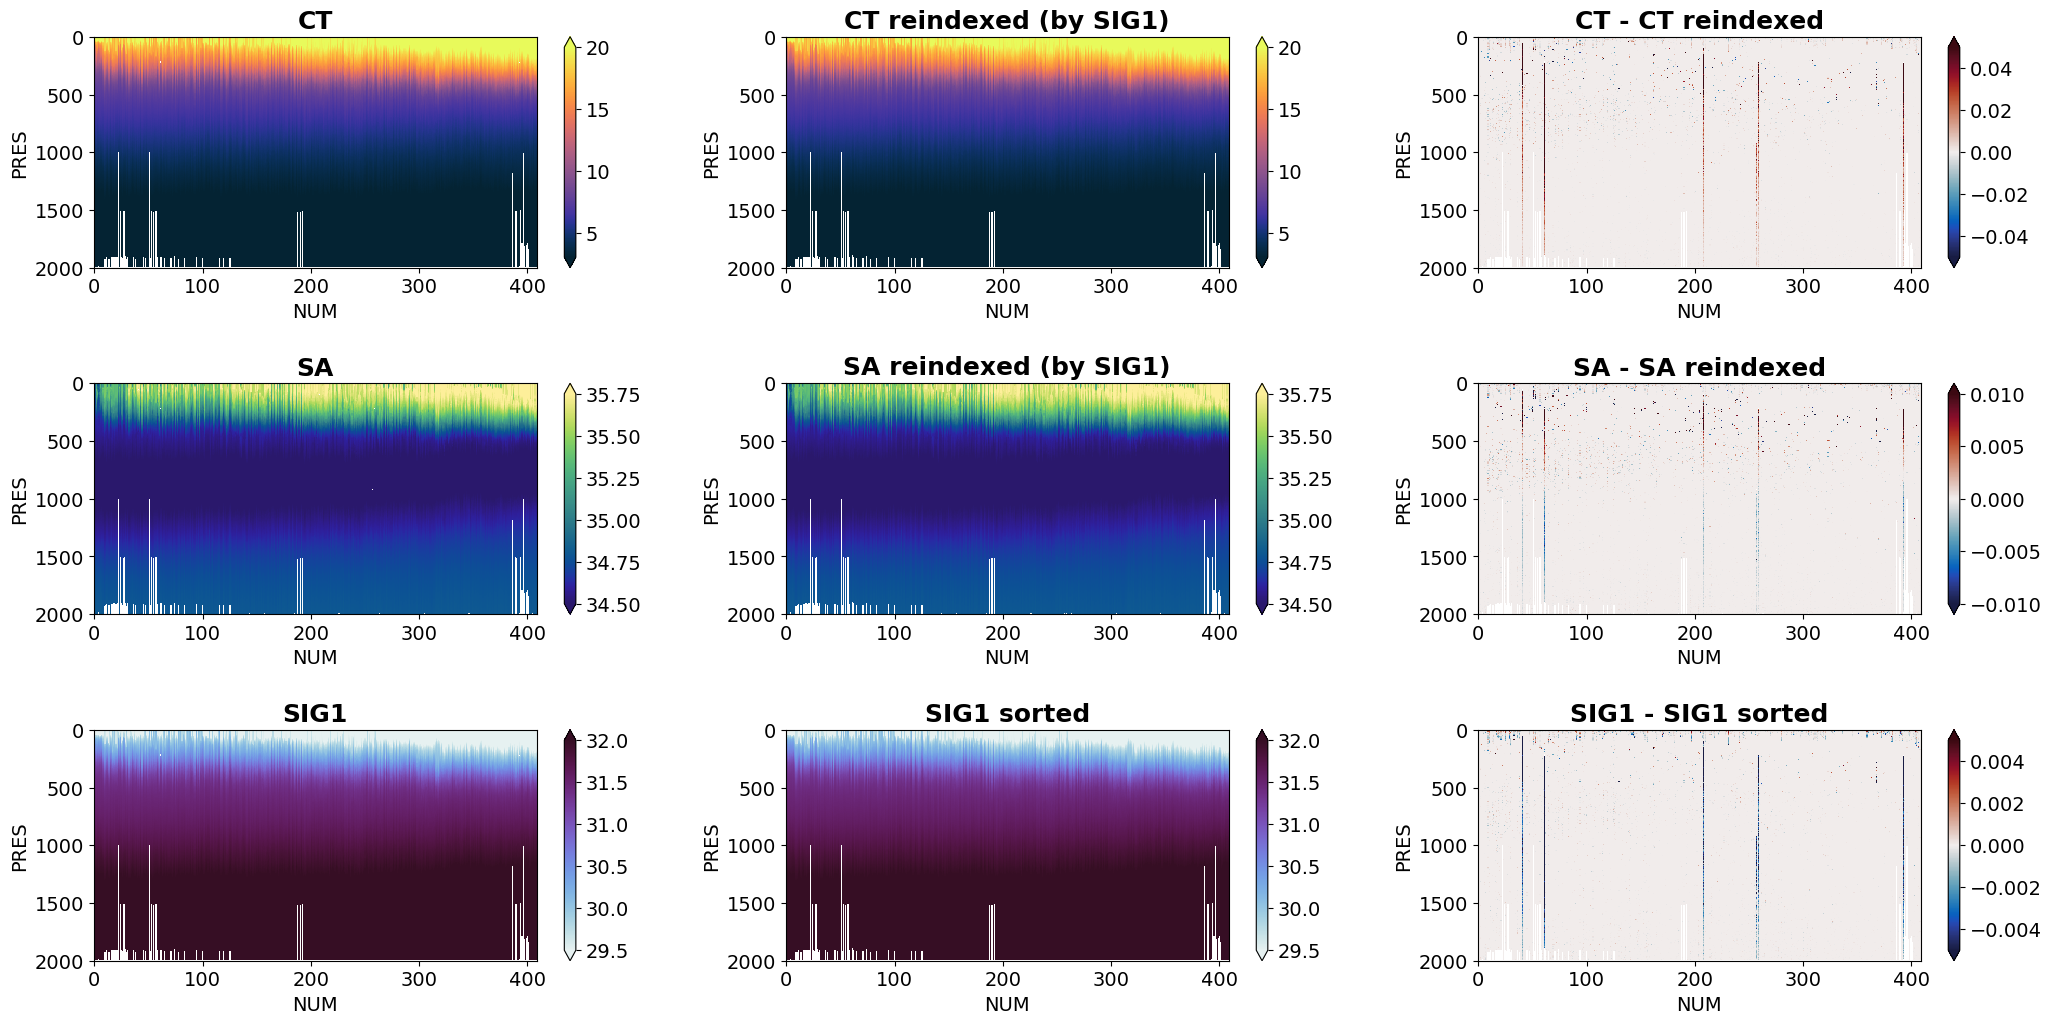

In [18]:
plt.figure(figsize=(25,12))

plt.subplot(331)
section_p.CT.plot(x=x, y='PRES', cmap=cmo.thermal, vmin=3, vmax=20, cbar_kwargs={'label':''})
plt.gca().invert_yaxis()
plt.title('CT')

plt.subplot(332)
section_p.CT_sort1.plot(x=x, y='PRES', cmap=cmo.thermal, vmin=3, vmax=20, cbar_kwargs={'label':''})
plt.gca().invert_yaxis()
plt.title('CT reindexed (by SIG1)')

plt.subplot(333)
(section_p.CT - section_p.CT_sort1).plot(x=x, y='PRES', cmap=cmo.balance, vmin=-0.05, vmax=0.05, cbar_kwargs={'label':''})
plt.gca().invert_yaxis()
plt.title('CT - CT reindexed')

plt.subplot(334)
section_p.SA.plot(x=x, y='PRES', cmap=cmo.haline, vmin=34.5, vmax=35.75, cbar_kwargs={'label':''})
plt.gca().invert_yaxis()
plt.title('SA')

plt.subplot(335)
section_p.SA_sort1.plot(x=x, y='PRES', cmap=cmo.haline, vmin=34.5, vmax=35.75, cbar_kwargs={'label':''})
plt.gca().invert_yaxis()
plt.title('SA reindexed (by SIG1)')

plt.subplot(336)
(section_p.SA - section_p.SA_sort1).plot(x=x, y='PRES', cmap=cmo.balance, vmin=-0.01, vmax=0.01, cbar_kwargs={'label':''})
plt.gca().invert_yaxis()
plt.title('SA - SA reindexed')

plt.subplot(337)
section_p.SIG1.plot(x=x, y='PRES', cmap=cmo.dense, vmin=29.5, vmax=32, cbar_kwargs={'label':''})
plt.gca().invert_yaxis()
plt.title('SIG1')

plt.subplot(338)
section_p.SIG1_sort1.plot(x=x, y='PRES', cmap=cmo.dense, vmin=29.5, vmax=32, cbar_kwargs={'label':''})
plt.gca().invert_yaxis()
plt.title('SIG1 sorted')

plt.subplot(339)
(section_p.SIG1 - section_p.SIG1_sort1).plot(x=x, y='PRES', cmap=cmo.balance, vmin=-0.005, vmax=0.005, cbar_kwargs={'label':''})
plt.gca().invert_yaxis()
plt.title('SIG1 - SIG1 sorted')

plt.subplots_adjust(wspace=0.25, hspace=0.5)

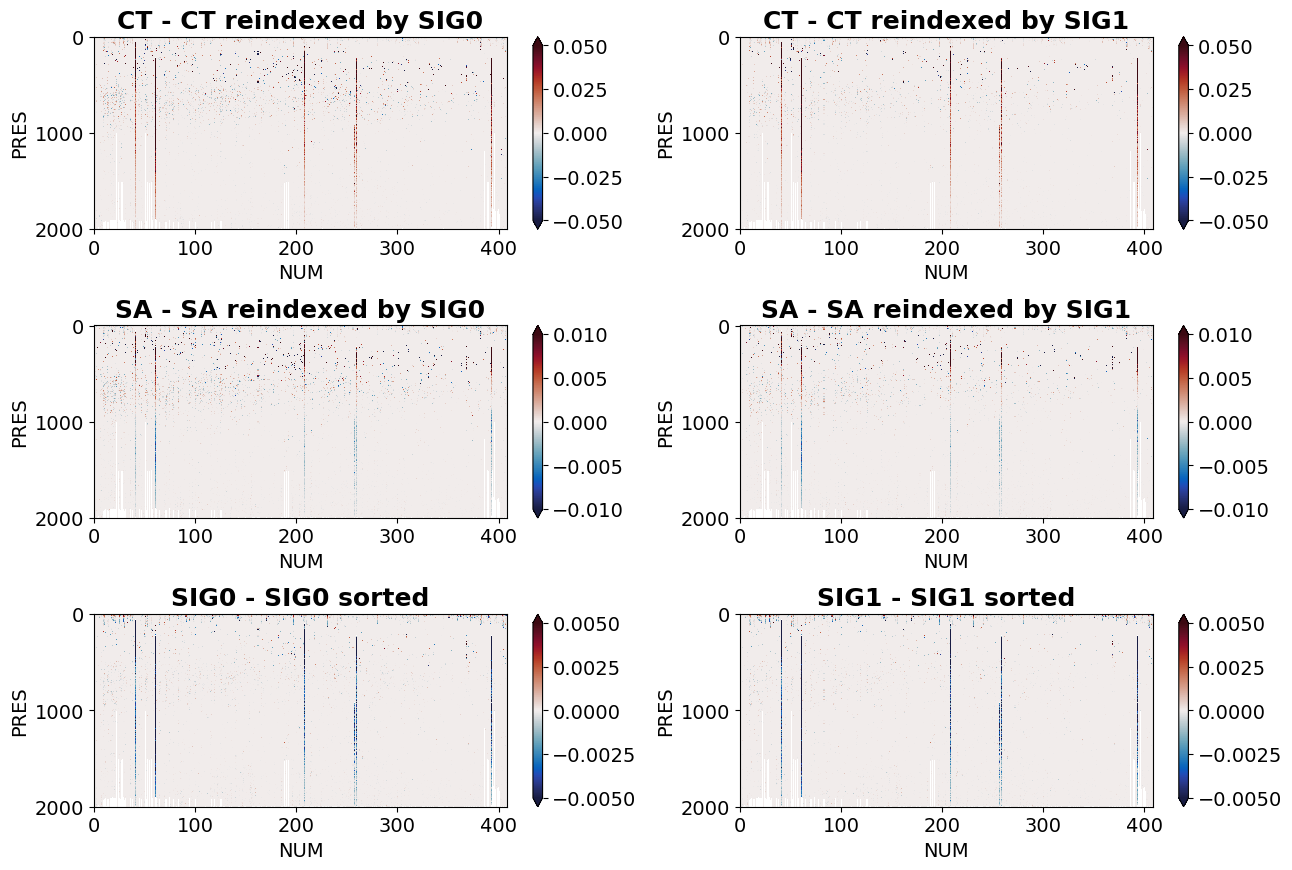

In [19]:
plt.figure(figsize=(15,10))

plt.subplot(321)
(section_p.CT - section_p.CT_sort0).plot(x=x, y='PRES', cmap=cmo.balance, vmin=-0.05, vmax=0.05, cbar_kwargs={'label':''})
plt.gca().invert_yaxis()
plt.title('CT - CT reindexed by SIG0')

plt.subplot(322)
(section_p.CT - section_p.CT_sort1).plot(x=x, y='PRES', cmap=cmo.balance, vmin=-0.05, vmax=0.05, cbar_kwargs={'label':''})
plt.gca().invert_yaxis()
plt.title('CT - CT reindexed by SIG1')

plt.subplot(323)
(section_p.SA - section_p.SA_sort0).plot(x=x, y='PRES', cmap=cmo.balance, vmin=-0.01, vmax=0.01, cbar_kwargs={'label':''})
plt.gca().invert_yaxis()
plt.title('SA - SA reindexed by SIG0')

plt.subplot(324)
(section_p.SA - section_p.SA_sort1).plot(x=x, y='PRES', cmap=cmo.balance, vmin=-0.01, vmax=0.01, cbar_kwargs={'label':''})
plt.gca().invert_yaxis()
plt.title('SA - SA reindexed by SIG1')

plt.subplot(325)
(section_p.SIG0 - section_p.SIG0_sort0).plot(x=x, y='PRES', cmap=cmo.balance, vmin=-0.005, vmax=0.005, cbar_kwargs={'label':''})
plt.gca().invert_yaxis()
plt.title('SIG0 - SIG0 sorted')

plt.subplot(326)
(section_p.SIG1 - section_p.SIG1_sort1).plot(x=x, y='PRES', cmap=cmo.balance, vmin=-0.005, vmax=0.005, cbar_kwargs={'label':''})
plt.gca().invert_yaxis()
plt.title('SIG1 - SIG1 sorted')

plt.subplots_adjust(wspace=0.25, hspace=0.5)

## Coord interp to rho

In [20]:
def interp_to_rho(rho_profile, var_profile, rho_grid, flag='group'):
    
    valid = ~np.isnan(rho_profile) & ~np.isnan(var_profile)
    rho_nonan = rho_profile[valid]
    var_nonan = var_profile[valid]

    if len(rho_nonan) < 3 or len(var_nonan) < 3:
        return np.full_like(rho_grid, np.nan)

    if flag == 'group':
        _, idx = np.unique(rho_nonan, return_index=True)
        rho_nonan = rho_nonan[idx]
        var_nonan = var_nonan[idx]

    fvar = interpolate.PchipInterpolator(rho_nonan, var_nonan, extrapolate=False)
    return fvar(rho_grid)

In [21]:
def get_ds_rho(ds_z, da_SIG, rho_grid, variables, dim1='PROF', dim2='PRES'):

    xrs = []
    rho_size = rho_grid.size
    
    for var in variables:
        var_interp = xr.apply_ufunc(interp_to_rho, da_SIG, ds_z[var],
            input_core_dims=[[dim2], [dim2]],
            output_core_dims=[['rho_grid']],
            dask_gufunc_kwargs={'output_sizes': {'rho_grid': rho_size}},
            vectorize=True,
            dask='parallelized',
            kwargs={'rho_grid': rho_grid},
            output_dtypes=[ds_z[var].dtype])
        print(f'Completed comp for {var}')
        var_interp = xr.DataArray(
            data=var_interp.data,
            dims=[dim1, 'rho_grid'],
            coords={'rho_grid': rho_grid, dim1: ds_z[dim1]},
            name=var)
        xrs.append(var_interp)
        print(f'Completed {var}')
    
    ds_rho = xr.merge(xrs)
    print(f'Completed merge')
    ds_rho = ds_rho.assign_coords(LAT  =(dim1, ds_z.LAT.data))
    ds_rho = ds_rho.assign_coords(LON  =(dim1, ds_z.LON.data))
    ds_rho = ds_rho.assign_coords(NUM  =(dim1, ds_z.NUM.data))
    ds_rho = ds_rho.assign_coords(TIME =(dim1, ds_z.TIME.data))
    
    return ds_rho

In [22]:
variables = ['CT','CT_sort0','CT_sort1','SA','SA_sort0','SA_sort1','SIG0','SIG0_sort0','SIG1','SIG1_sort1','PRESSURE','PRESSURE_sort0','PRESSURE_sort1','PRES']
section_rho0 = get_ds_rho(section_p, section_p.SIG0_sort0, np.arange(22,28,0.001), variables)
section_rho1 = get_ds_rho(section_p, section_p.SIG1_sort1, np.arange(26,33,0.001), variables)

Completed comp for CT
Completed CT
Completed comp for CT_sort0
Completed CT_sort0
Completed comp for CT_sort1
Completed CT_sort1
Completed comp for SA
Completed SA
Completed comp for SA_sort0
Completed SA_sort0
Completed comp for SA_sort1
Completed SA_sort1
Completed comp for SIG0
Completed SIG0
Completed comp for SIG0_sort0
Completed SIG0_sort0
Completed comp for SIG1
Completed SIG1
Completed comp for SIG1_sort1
Completed SIG1_sort1
Completed comp for PRESSURE
Completed PRESSURE
Completed comp for PRESSURE_sort0
Completed PRESSURE_sort0
Completed comp for PRESSURE_sort1
Completed PRESSURE_sort1


/home/amf2288/miniconda3/envs/Argo_Feb_25/lib/python3.11/site-packages/numpy/lib/function_base.py:2506: RuntimeWarning: invalid value encountered in cast
  output[index] = result


Completed comp for PRES
Completed PRES
Completed merge
Completed comp for CT
Completed CT
Completed comp for CT_sort0
Completed CT_sort0
Completed comp for CT_sort1
Completed CT_sort1
Completed comp for SA
Completed SA
Completed comp for SA_sort0
Completed SA_sort0
Completed comp for SA_sort1
Completed SA_sort1
Completed comp for SIG0
Completed SIG0
Completed comp for SIG0_sort0
Completed SIG0_sort0
Completed comp for SIG1
Completed SIG1
Completed comp for SIG1_sort1
Completed SIG1_sort1
Completed comp for PRESSURE
Completed PRESSURE
Completed comp for PRESSURE_sort0
Completed PRESSURE_sort0
Completed comp for PRESSURE_sort1
Completed PRESSURE_sort1
Completed comp for PRES
Completed PRES
Completed merge


## Coord interp to p_bar

In [23]:
def interp_to_pmean(var_profile, pmean_smooth, pmean_grid, roll):

    try:
        valid = ~np.isnan(var_profile) & ~np.isnan(pmean_smooth)
        var_nonan = var_profile[valid]
        pmean_nonan = pmean_smooth[valid]

        fvar = interpolate.PchipInterpolator(pmean_nonan, var_nonan, extrapolate=False)
        return fvar(pmean_grid)

    except ValueError:
        return np.full_like(pmean_grid, np.nan)
        print(f"ValueError")

In [24]:
def get_ds_pmean(ds_rho, pres_var, pmean_grid, variables, roll=50, dim1='PROF', dim2='rho_grid'):
    
    xrs = []
    pmean_size = pmean_grid.size
    
    # 1. Mean pressure profile
    pres_profile = ds_rho[pres_var].mean(dim1)

    # 2. Sort the mean profile
    sort_idx_mean = sorting_index_from_sig(pres_profile.values)
    pres_profile_sorted = pres_profile.values[sort_idx_mean]

    # 3. Wrap back into DataArray
    pmean_smooth = xr.DataArray(
        pres_profile_sorted,
        dims=[dim2],
        coords={dim2: ds_rho[dim2]},
        name="pmean_smooth"
    )
    
    #pres_profile = ds_rho[pres_var].mean(dim1)
    #pmean_smooth = pres_profile.rolling(**{dim2: roll}, center=True).mean()
    
    for var in variables:
        var_interp = xr.apply_ufunc(interp_to_pmean, ds_rho[var], pmean_smooth,
                                   input_core_dims=[[dim2], [dim2]],
                                   output_core_dims=[['Pmean_grid']],
                                   dask_gufunc_kwargs={'output_sizes': {'Pmean_grid':pmean_size}},
                                   vectorize=True,
                                   dask='parallaleized',
                                   kwargs={'pmean_grid':pmean_grid, 'roll':roll},
                                   output_dtypes=[ds_rho[var].dtype])
        print(f'Completed comp for {var}')
        var_interp = xr.DataArray(
            data=var_interp.data,
            dims=[dim1,'pmean_grid'],
            coords={'pmean_grid': pmean_grid, dim1: ds_rho[dim1]},
            name=var)
        xrs.append(var_interp)
        print(f'Completed {var}')
        
    ds_pmean = xr.merge(xrs)
    print(f'Completed merge')
    ds_pmean = ds_pmean.assign_coords(LAT = (dim1, ds_rho.LAT.data))
    ds_pmean = ds_pmean.assign_coords(LON = (dim1, ds_rho.LON.data))
    ds_pmean = ds_pmean.assign_coords(NUM = (dim1, ds_rho.NUM.data))
    ds_pmean = ds_pmean.assign_coords(TIME = (dim1, ds_rho.TIME.data))
    
    return ds_pmean

In [25]:
section_pmean0 = get_ds_pmean(section_rho0, 'PRESSURE_sort0', np.linspace(0, 2000, 1001), variables)

Completed comp for CT
Completed CT
Completed comp for CT_sort0
Completed CT_sort0
Completed comp for CT_sort1
Completed CT_sort1
Completed comp for SA
Completed SA
Completed comp for SA_sort0
Completed SA_sort0
Completed comp for SA_sort1
Completed SA_sort1
Completed comp for SIG0
Completed SIG0
Completed comp for SIG0_sort0
Completed SIG0_sort0
Completed comp for SIG1
Completed SIG1
Completed comp for SIG1_sort1
Completed SIG1_sort1
Completed comp for PRESSURE
Completed PRESSURE
Completed comp for PRESSURE_sort0
Completed PRESSURE_sort0
Completed comp for PRESSURE_sort1
Completed PRESSURE_sort1


/home/amf2288/miniconda3/envs/Argo_Feb_25/lib/python3.11/site-packages/numpy/lib/function_base.py:2506: RuntimeWarning: invalid value encountered in cast
  output[index] = result


Completed comp for PRES
Completed PRES
Completed merge


Okay I think I know what's going on. I've sorted the densities and reindexed the tracer variables, but I'm passing it on an old pressure variable? The pairing I need going into the density conversion algorithm is the SIG0_sort or SIG1_sort paired with PRES! Make sure that for individiual profiles, this produces a monotonically increasing sequence. Then check what's going on when many profiles are averaged together.

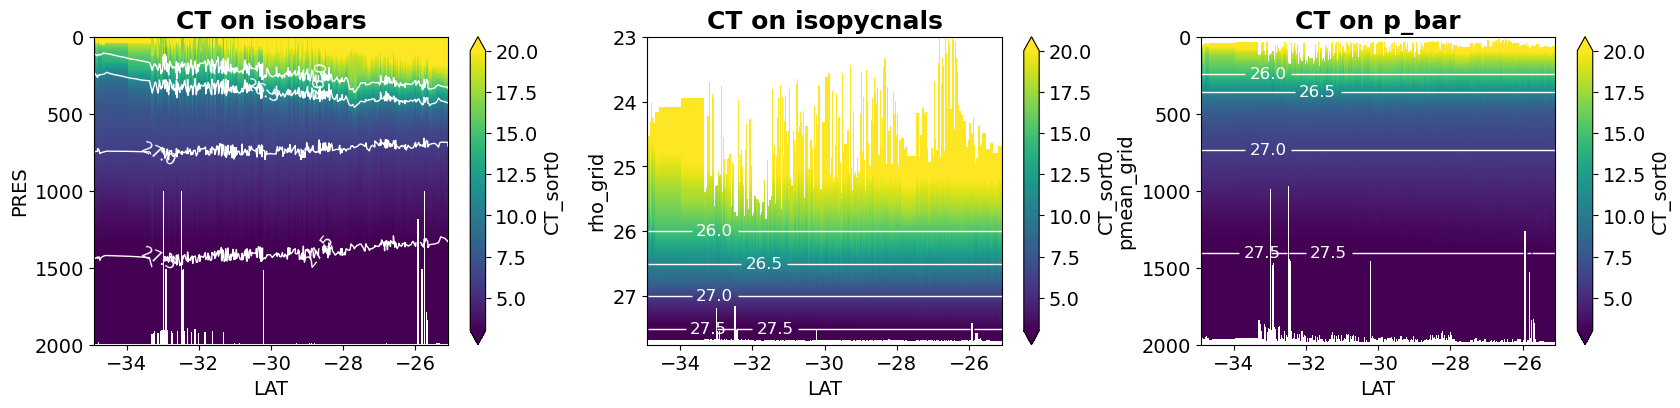

In [29]:
plt.figure(figsize=(20,4))
levels = [26,26.5,27,27.5]
x='LAT'

plt.subplot(131)
section_p.CT_sort0.plot(x=x,y='PRES',vmin=3,vmax=20)
contours1 = plt.contour(section_p.LAT.values, section_p.PRES.values, section_p.SIG0_sort0.values.T, levels=levels, colors='white', linewidths=1)
plt.clabel(contours1, inline=True, fontsize=12, fmt="%.1f")
plt.gca().invert_yaxis()
#plt.ylim(1800,100)
plt.title('CT on isobars')

plt.subplot(132)
section_rho0.CT_sort0.plot(x=x, y='rho_grid',vmin=3,vmax=20)
contours2 = plt.contour(section_rho0.LAT.values, section_rho0.rho_grid.values, section_rho0.SIG0_sort0.values.T, levels=levels, colors='white', linewidths=1)
plt.clabel(contours2, inline=True, fontsize=12, fmt="%.1f")
plt.gca().invert_yaxis()
plt.ylim(27.75,23)
plt.title('CT on isopycnals')

plt.subplot(133)
section_pmean0.CT_sort0.plot(x=x, y='pmean_grid',vmin=3,vmax=20)
contours3 = plt.contour(section_pmean0.LAT.values, section_pmean0.pmean_grid.values, section_pmean0.SIG0_sort0.values.T, levels=levels, colors='white', linewidths=1)
plt.clabel(contours3, inline=True, fontsize=12, fmt="%.1f")
plt.gca().invert_yaxis()
#plt.ylim(1800,100)
plt.title('CT on p_bar')

plt.subplots_adjust(wspace=0.25)

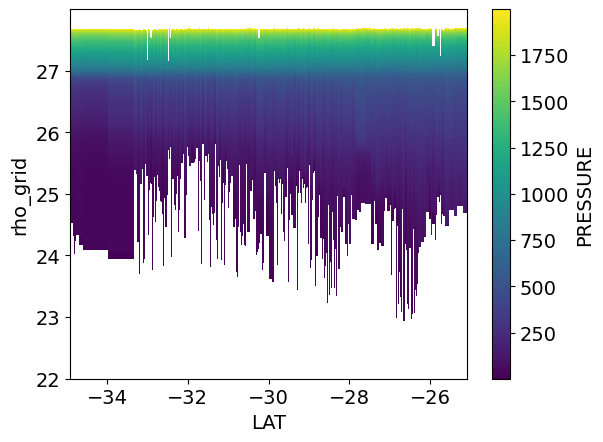

In [27]:
section_rho0.PRESSURE.plot(x='LAT', y='rho_grid')

In [29]:
# Check PRESSURE values in section_rho0
print("section_rho0.PRESSURE statistics:")
print(f"Min: {section_rho0.PRESSURE.min().values}")
print(f"Max: {section_rho0.PRESSURE.max().values}")
print(f"Mean: {np.nanmean(section_rho0.PRESSURE.values)}")
print(f"Number of NaNs: {np.isnan(section_rho0.PRESSURE.values).sum()}")
print(f"Number of negative values: {(section_rho0.PRESSURE.values < 0).sum()}")
print(f"Total values: {section_rho0.PRESSURE.size}")
print(f"\nUnique values (first 20): {np.unique(section_rho0.PRESSURE.values)[~np.isnan(np.unique(section_rho0.PRESSURE.values))][:20]}")

section_rho0.PRESSURE statistics:
Min: 0.9049469232559204
Max: 1997.9942626953125
Mean: 435.9950256347656
Number of NaNs: 1178375
Number of negative values: 0
Total values: 2454000

Unique values (first 20): [0.9049469 0.9715911 0.9787295 1.0798157 1.1016359 1.1266906 1.1313384
 1.2163864 1.2312535 1.3603833 1.4504248 1.488965  1.6169384 1.6688129
 1.7161745 1.7442429 1.7456858 1.7803096 1.8595194 1.8708184]
